# CS 512 F24: Assignment 5

**Name:** Tamilarasee Sethuraj

**Student ID:** A20553416




# 1. Dataset Preparation
CIFAR-10 contains 10 classes (e.g., airplane, car, bird, cat, deer). The Cats and Dogs contains tWO classes (cats, dogs).
- Load the dataset using Keras. 
- Resize all images to 224x224 pixels, and normalize pixel values to [0, 1]. 
- Split the data into training and testing sets Further split the testing set into a testing and validation subsets. Set up data loading for each.

In [2]:
# Step 1: Install necessary libraries
%pip install transformers tensorflow

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: C:\Users\User\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [3]:
# Step 2: Import libraries
from transformers import ViTFeatureExtractor, TFViTModel
from tensorflow.keras import layers, Model, optimizers
from tensorflow.keras.datasets import cifar10
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# Step 3: Load and preprocess CIFAR-10 dataset
(img_train, label_train), (img_test, label_test) = cifar10.load_data()

In [5]:
# Limit to the first 2000 images and labels in the training set
img_train = img_train[:2000]
label_train = label_train[:2000]

In [6]:
# Similarly, limit the test set
img_test = img_test[:100]
label_test = label_test[:100]

In [7]:

# Resize CIFAR-10 images from 32x32 to 224x224 and normalize pixel values
IMG_SIZE = 224
img_train = tf.image.resize(img_train, (IMG_SIZE, IMG_SIZE)) / 255.0
img_test = tf.image.resize(img_test, (IMG_SIZE, IMG_SIZE)) / 255.0

In [8]:
BATCH_SIZE = 10 # 32
val_size = int(0.5 * len(img_test))

train_ds = tf.data.Dataset.from_tensor_slices((img_train, label_train)).batch(BATCH_SIZE).shuffle(100)
val_ds = tf.data.Dataset.from_tensor_slices((img_test[:val_size], label_test[:val_size])).batch(BATCH_SIZE)
test_ds = tf.data.Dataset.from_tensor_slices((img_test[val_size:], label_test[val_size:])).batch(BATCH_SIZE)

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.prefetch(AUTOTUNE)
val_ds = val_ds.prefetch(AUTOTUNE)
test_ds = test_ds.prefetch(AUTOTUNE)

# 2. Standard Vision Transformer (ViT) Model
1. Implement the ViT Model:
- Load a pretrained Vision Transformer (ViT) model from Hugging Face using the TFVi TModel class. 
- Add a classification head after the ViT blocks, with 10 output units (one for each class in CIFAR-10), or 1 output unit for the Cats and Dogs problem). 
- Compile the model with an appropriate optimizer, loss function, and metrics. 

2. Training: 
- Train the model on the training set. 
- Save checkpoints periodically, and log training/validation loss and accuracy. 

3. Evaluation:
- Evaluate the model on the test set, reporting accuracy and other relevant metrics.
- Plot the training and validation accuracy and loss over epochs.


In [9]:
# Define the Standard Vision Transformer (ViT) Model
# Custom wrapper layer for the ViT model
class ViTModelLayer(layers.Layer):
    def __init__(self, vit_model, **kwargs):
        super(ViTModelLayer, self).__init__(**kwargs)
        self.vit_model = vit_model

    def call(self, inputs):
        # Adjust dimensions to match the expected input shape for ViT: (batch_size, 3, height, width)
        inputs = tf.transpose(inputs, [0, 3, 1, 2])
        # Pass the adjusted input through the ViT model
        vit_output = self.vit_model(pixel_values=inputs).last_hidden_state[:, 0]
        return vit_output
    
    def get_config(self):
        config = super().get_config()
        config.update({"vit_model": self.vit_model})
        return config   

# Define the model creation function
def create_vit_model(num_classes):
    # Load the pretrained Vision Transformer model from Hugging Face
    vit_model = TFViTModel.from_pretrained("google/vit-base-patch16-224-in21k")

    # Define input layer
    input_layer = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))

    # Wrap ViT model in the custom layer
    vit_output = ViTModelLayer(vit_model)(input_layer)

    # Add a classification head
    output_layer = layers.Dense(num_classes, activation='softmax')(vit_output)

    # Create the final model
    model = Model(inputs=input_layer, outputs=output_layer)
    return model



In [10]:
# Step 5: Instantiate the ViT model and compile it
num_classes = 10  # CIFAR-10 has 10 classes
vit_model = create_vit_model(num_classes)
vit_model.compile(optimizer=optimizers.Adam(learning_rate=1e-4),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

vit_model.summary()
vit_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    "vit_model_checkpoint.keras", save_best_only=True, monitor='val_accuracy'
)




All PyTorch model weights were used when initializing TFViTModel.

All the weights of TFViTModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFViTModel for predictions without further training.


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vi_t_model_layer                │ (None, 768)            │             0 │
│ (ViTModelLayer)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │         7,690 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,690 (30.04 KB)

 Trainable params: 7,690 (30.04 KB)

 Non-trainable params: 0 (0.00 B)

In [11]:
# Step 6: Train the Standard ViT Model
import time

EPOCHS = 10
start_time = time.time()

vit_history = vit_model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS,callbacks=[vit_checkpoint])

training_time = time.time() - start_time
print(f"Total training time: {training_time:.2f} seconds")

Epoch 1/10


200/200 ━━━━━━━━━━━━━━━━━━━━ 1007s 5s/step - accuracy: 0.2608 - loss: 2.2113 - val_accuracy: 0.6200 - val_loss: 1.9489
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 892s 4s/step - accuracy: 0.6540 - loss: 1.8730 - val_accuracy: 0.8200 - val_loss: 1.6230
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 900s 5s/step - accuracy: 0.7899 - loss: 1.5709 - val_accuracy: 0.8800 - val_loss: 1.3572
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 916s 5s/step - accuracy: 0.8290 - loss: 1.3324 - val_accuracy: 0.9000 - val_loss: 1.1466
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 927s 5s/step - accuracy: 0.8572 - loss: 1.1427 - val_accuracy: 0.9200 - val_loss: 0.9831
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 922s 5s/step - accuracy: 0.8579 - loss: 1.0074 - val_accuracy: 0.9200 - val_loss: 0.8558
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 899s 4s/step - accuracy: 0.8800 - loss: 0.8761 - val_accuracy: 0.9200 - val_loss: 0.7546
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 899s 4s/step - accuracy: 0.8840 - loss: 0.7837 - val_accuracy: 0.94

In [12]:
vit_training_time = training_time

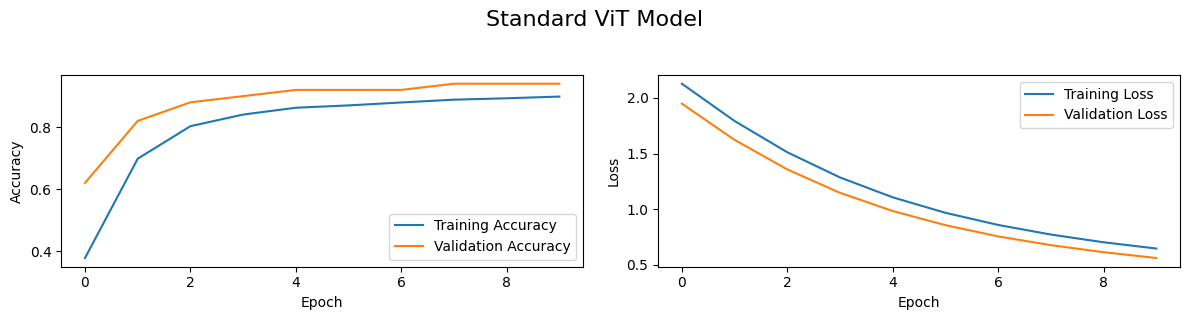

In [13]:
# Plot training and validation curves
plt.figure(figsize=(12, 3))
plt.suptitle("Standard ViT Model", fontsize=16, y=1.05)
plt.subplot(1, 2, 1)
plt.plot(vit_history.history['accuracy'], label='Training Accuracy')
plt.plot(vit_history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(vit_history.history['loss'], label='Training Loss')
plt.plot(vit_history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout() 
plt.show()


In [14]:
# Step 7: Evaluate the Standard ViT Model
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, accuracy_score
import seaborn as sns

def evaluate_model(model, test_ds, model_name):
    y_pred = []
    y_true = []
    for images, labels in test_ds:
        predictions = model.predict(images)
        y_pred.extend(np.argmax(predictions, axis=1))
        y_true.extend(labels.numpy())
    
    accuracy = accuracy_score(y_true, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')
    cm = confusion_matrix(y_true, y_pred)
    
    print(f"{model_name} Metrics:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    
    plt.figure(figsize=(10, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{model_name} Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()
    
    return accuracy, precision, recall, f1



1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
ViT Metrics:
Accuracy: 0.7800
Precision: 0.8083
Recall: 0.7800
F1-Score: 0.7742


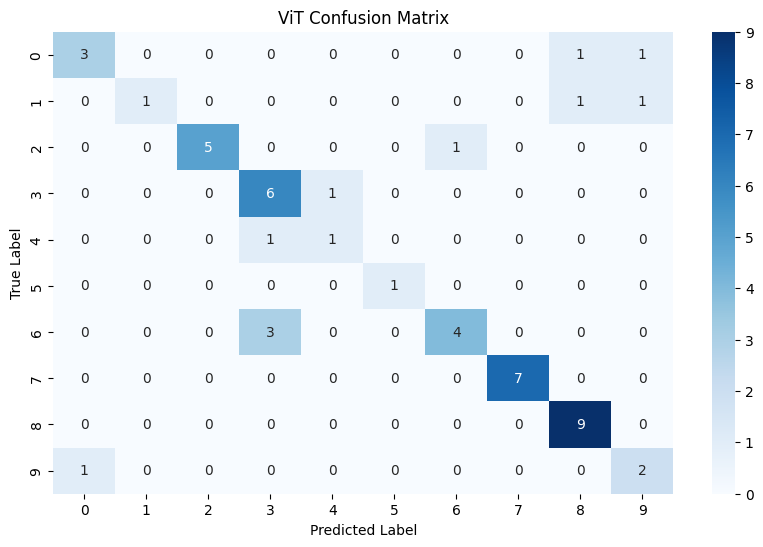

In [15]:
vit_accuracy, vit_precision, vit_recall, vit_f1 = evaluate_model(vit_model, test_ds, "ViT")

# 3. Hybrid VGG16 + ViT Model
1. Pretrained VGG16 for Feature Extraction:
- Use pretrained VGG16 layers up to block3_conv3 or up to block5_conv3 to extract initial image features. The advantage of block5_conv3 is that it produces a smaller output (14x14x512) for ViT
- Freeze these VGG16 layers to use them as a fixed feature extractor. 



Starter Code for VGG16 + ViT network
To make the ViT work with intermediate feature maps as input, you need to modify the configuration of the ViTmodel and pass it via .from_pretrained() function.

ViTConfig() is the configuration class to store the configuration of a ViTModel. It is used to instantiate an ViT model according to the specified arguments and model architecture.
Link: https://huggingface.co/docs/transformers/main/en/model_doc/vit#transformers.ViTConfigLinks to an external site.
To make it work with with intermediate feature maps as input, you need to adjust the following two/three arguments:
image_size and num_channels. These values should match the output of VGG16 (block5_conv3 or block3_conv3).
For the patch size, as specified in the original paper (page 5), "For the hybrids, we feed the intermediate feature maps into ViT with patch size of one “pixel” ".  Thus, we will set the patch size to 1.
When loading the pretrained model, the config Class should be passed via .from_pretrained() function ('config' argument). Additionally, the 'ignore_mismatched_sizes' should be set to True.
Link: https://huggingface.co/docs/transformers/main/en/main_classes/model#transformers.PreTrainedModel.from_pretrained

2. Implement the Hybrid Model: 
- After extracting features with VGG16, feed the output into the ViT blocks. 
- Ensure the output of VGG16 layers matches the ViT input shape requirements. 
- Add a classification head after the ViT blocks to produce predictions. 



In [16]:
from tensorflow.keras.applications import VGG16
from transformers import ViTConfig

def create_hybrid_model(num_classes):
    vgg_input = layers.Input(shape=(224, 224, 3))

    vgg_model = VGG16(weights='imagenet', include_top=False, input_tensor=vgg_input)
    for layer in vgg_model.layers:
        layer.trainable = False
    vgg_output = vgg_model.get_layer('block5_conv3').output
    print("VGG block5_conv3 Output shape:", vgg_output.shape)

   
    vit_config = ViTConfig(
        image_size=14,
        patch_size=1,
        num_channels=512,
        num_classes=num_classes
    )
    vit_model = TFViTModel.from_pretrained("google/vit-base-patch16-224-in21k",config=vit_config,ignore_mismatched_sizes=True)
    vit_output = ViTModelLayer(vit_model)(vgg_output)
    hybrid_output = layers.Dense(num_classes, activation='softmax')(vit_output)
    hybrid_model = Model(inputs=vgg_input, outputs=hybrid_output)
    return hybrid_model

3. Training and Evaluation:
- Train the hybrid model on the CIFAR-10 or Cats and Dogs training set. 
- Evaluate the hybrid model on the test set, tracking the same metrics as in Task 2.
- Save checkpoints and visualize some predictions on test images.




The visualization for test images is done for both models as comparison in the next section

In [17]:
hybrid_model = create_hybrid_model(num_classes)
hybrid_model.compile(optimizer=optimizers.Adam(learning_rate=1e-4),
                     loss='sparse_categorical_crossentropy',
                     metrics=['accuracy'])

hybrid_model.summary()




VGG block5_conv3 Output shape: (None, 14, 14, 512)


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFViTModel: ['embeddings.patch_embeddings.projection.weight']
- This IS expected if you are initializing TFViTModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFViTModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFViTModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFViTModel for predictions without further training.
Some weights of TFViTModel were not initialized from the model checkpoint are newly initialized because the shapes did not match:
- embeddings.patch_embeddings.projection.weight: found sh

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vi_t_model_layer_1              │ (None, 768)            │             0 │
│ (ViTModelLayer)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         7,690 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,722,378 (56.16 MB)

 Trainable params: 7,690 (30.04 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [18]:
# Step 6: Train the Standard ViT Model
import time

start_time = time.time()

hybrid_history = hybrid_model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS,
                                  callbacks=[tf.keras.callbacks.ModelCheckpoint('hybrid_model_checkpoint.keras', save_best_only=True, monitor='val_accuracy')])

hybrid_training_time = time.time() - start_time

print(f"Total training time: {hybrid_training_time:.2f} seconds")

Epoch 1/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1499s 7s/step - accuracy: 0.0986 - loss: 2.3055 - val_accuracy: 0.1000 - val_loss: 2.2965
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1494s 7s/step - accuracy: 0.1045 - loss: 2.2974 - val_accuracy: 0.1800 - val_loss: 2.2938
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1491s 7s/step - accuracy: 0.1403 - loss: 2.2927 - val_accuracy: 0.1200 - val_loss: 2.2876
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1500s 7s/step - accuracy: 0.1226 - loss: 2.2872 - val_accuracy: 0.1000 - val_loss: 2.2872
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1489s 7s/step - accuracy: 0.1722 - loss: 2.2844 - val_accuracy: 0.2200 - val_loss: 2.2728
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1490s 7s/step - accuracy: 0.1651 - loss: 2.2810 - val_accuracy: 0.1600 - val_loss: 2.2785
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1499s 7s/step - accuracy: 0.1768 - loss: 2.2780 - val_accuracy: 0.1800 - val_loss: 2.2711
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1498s 7s/step - accuracy: 0.1507 - loss: 2.2736 - 

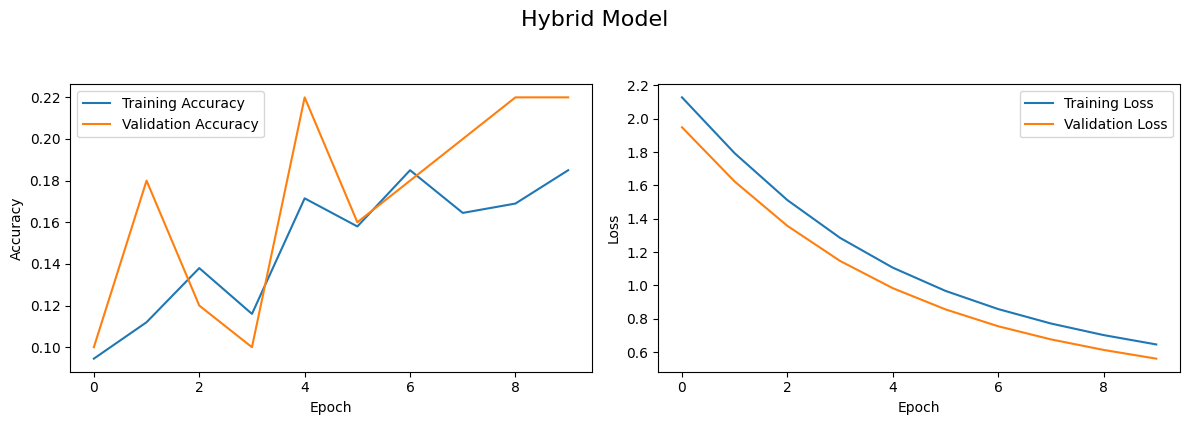

In [20]:
# Plot training and validation curves
plt.figure(figsize=(12, 4))
plt.suptitle("Hybrid Model", fontsize=16, y=1.05)
plt.subplot(1, 2, 1)
plt.plot(hybrid_history.history['accuracy'], label='Training Accuracy')
plt.plot(hybrid_history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(vit_history.history['loss'], label='Training Loss')
plt.plot(vit_history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
Hybrid_model Metrics:
Accuracy: 0.1800
Precision: 0.2031
Recall: 0.1800
F1-Score: 0.1698


C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


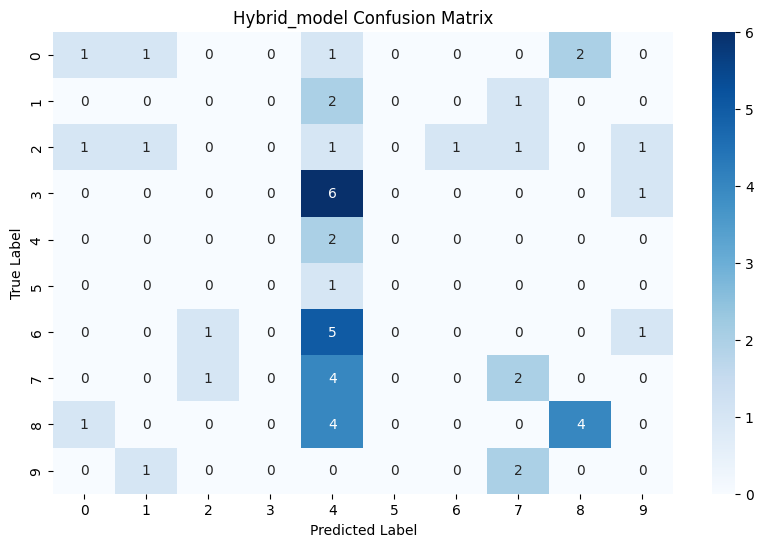

In [21]:
hybrid_accuracy, hybrid_precision, hybrid_recall, hybrid_f1 = evaluate_model(hybrid_model, test_ds, "Hybrid_model")

# 4. Analysis and Comparison
## 1. Performance Analysis:
- Compare the performance of the standard ViT and hybrid VGG16 + ViT models. 


1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step


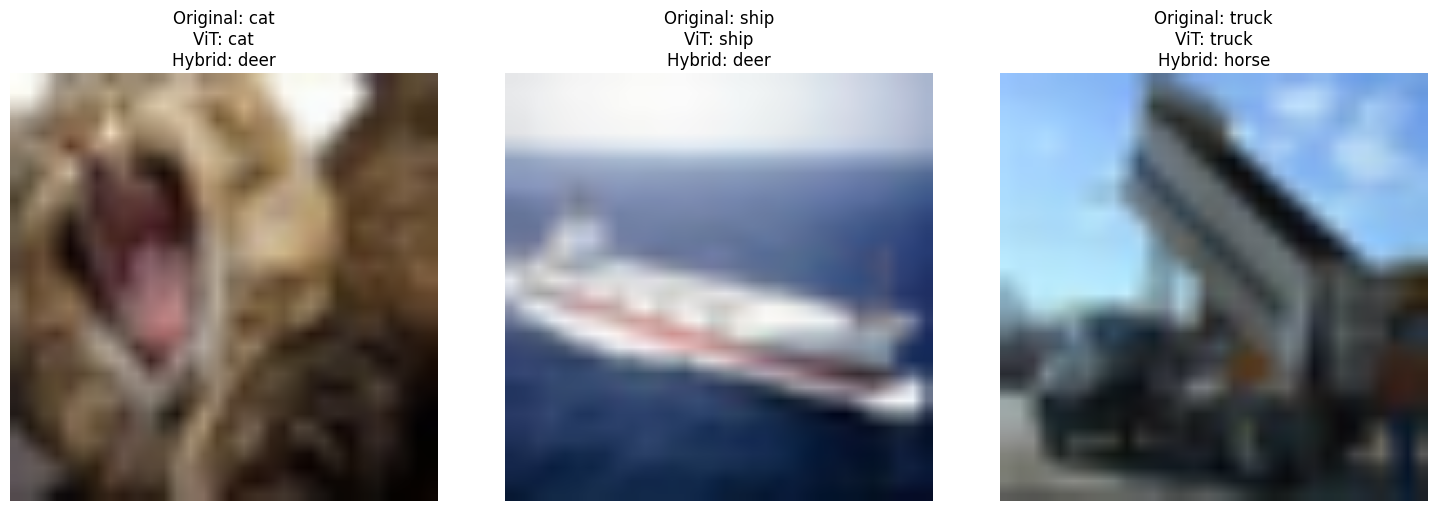

In [30]:
import numpy as np
import matplotlib.pyplot as plt

def plot_predictions(images, true_labels, vit_predictions, hybrid_predictions, class_names):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        
    true_labels = true_labels.flatten()
    vit_predictions = vit_predictions.flatten()
    hybrid_predictions = hybrid_predictions.flatten()
    
    for i, ax in enumerate(axes):
        
        ax.imshow(images[i])
        ax.axis('off')
        ax.set_title(f"Original: {class_names[true_labels[i]]}\n"
                     f"ViT: {class_names[vit_predictions[i]]}\n"
                     f"Hybrid: {class_names[hybrid_predictions[i]]}")
    
    plt.tight_layout()
    plt.show()

# CIFAR-10 class names
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
               'dog', 'frog', 'horse', 'ship', 'truck']

# Select 3 random images from the test set
num_samples = 3
sample_indices = np.random.choice(len(test_ds), num_samples, replace=False)

images = []
true_labels = []
vit_predictions = []
hybrid_predictions = []

for images_batch, labels_batch in test_ds.take(1):
    images = images_batch.numpy()[sample_indices]
    true_labels = labels_batch.numpy()[sample_indices]
    
    vit_pred = vit_model.predict(images_batch)
    vit_predictions = np.argmax(vit_pred, axis=1)[sample_indices]
    
    hybrid_pred = hybrid_model.predict(images_batch)
    hybrid_predictions = np.argmax(hybrid_pred, axis=1)[sample_indices]

plot_predictions(images, true_labels, vit_predictions, hybrid_predictions, class_names)

- Report quantitative metrics such as accuracy, loss, and training times. 

In [36]:
import pandas as pd

print("Metrics comparison on Test results:\n")
metrics_data = {
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'Training Time (s)'],
    'Standard ViT': [vit_accuracy, vit_precision, vit_recall, vit_f1,vit_training_time],
    'Hybrid ViT': [hybrid_accuracy, hybrid_precision, hybrid_recall, hybrid_f1,hybrid_training_time]
}

metrics_df = pd.DataFrame(metrics_data)
metrics_df = metrics_df.set_index('Metric')

print(metrics_df)

Metrics comparison on Test results:

                   Standard ViT    Hybrid ViT
Metric                                       
Accuracy               0.780000      0.180000
Precision              0.808273      0.203077
Recall                 0.780000      0.180000
F1 Score               0.774200      0.169791
Training Time (s)   9167.646462  14963.942730


In [42]:
print(f"Standard VIT Model:\n")
print(f"Validation loss:{vit_history.history['val_loss'][-1]:.2f}")
print(f"Validation acccuracy:{vit_history.history['val_accuracy'][-1]:.2f}")


print(f"\nHybrid VIT+VGG Model:\n")
print(f"Validation loss:{hybrid_history.history['val_loss'][-1]:.2f}")
print(f"Validation acccuracy:{hybrid_history.history['val_accuracy'][-1]:.2f}")

Standard VIT Model:

Validation loss:0.56
Validation acccuracy:0.94

Hybrid VIT+VGG Model:

Validation loss:2.26
Validation acccuracy:0.22


In [53]:
y_pred = []
y_true = []
for images, labels in test_ds:
    predictions = vit_model.predict(images)
    y_pred.extend(np.argmax(predictions, axis=1))
    y_true.extend(labels.numpy())
    
vit_cm = confusion_matrix(y_true, y_pred)

y_pred = []
y_true = []
for images, labels in test_ds:
    predictions = hybrid_model.predict(images)
    y_pred.extend(np.argmax(predictions, axis=1))
    y_true.extend(labels.numpy())
    
hybrid_cm = confusion_matrix(y_true, y_pred)   
    

1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 21s 21s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


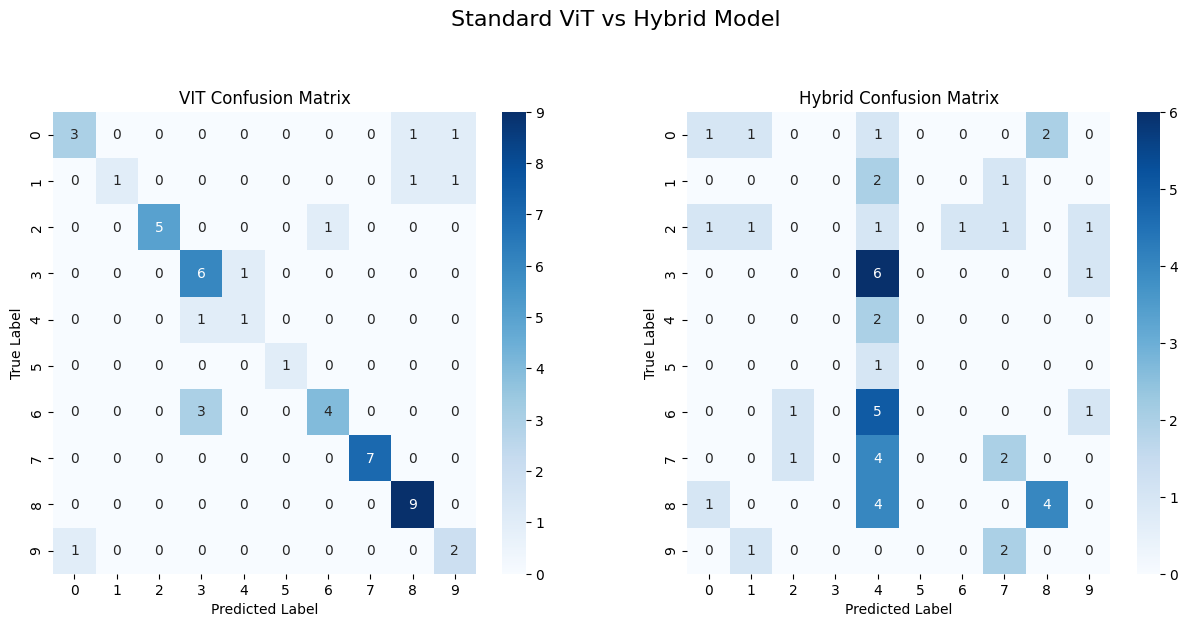

In [54]:
plt.figure(figsize=(15, 6))
plt.suptitle("Standard ViT vs Hybrid Model", fontsize=16, y=1.05)
plt.subplot(1, 2, 1)
sns.heatmap(vit_cm, annot=True, fmt='d', cmap='Blues')
plt.title(f'VIT Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.subplot(1, 2, 2)
sns.heatmap(hybrid_cm, annot=True, fmt='d', cmap='Blues')
plt.title(f'Hybrid Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

- Visualize any training or validation differences with relevant plots. 

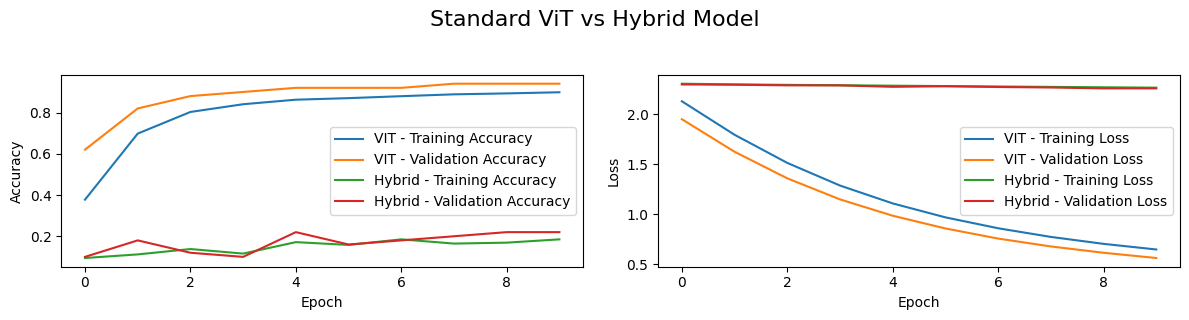

In [55]:
# Plot training and validation curves
plt.figure(figsize=(12, 3))
plt.suptitle("Standard ViT vs Hybrid Model", fontsize=16, y=1.05)
plt.subplot(1, 2, 1)
plt.plot(vit_history.history['accuracy'], label='VIT - Training Accuracy')
plt.plot(vit_history.history['val_accuracy'], label='VIT - Validation Accuracy')
plt.plot(hybrid_history.history['accuracy'], label='Hybrid - Training Accuracy')
plt.plot(hybrid_history.history['val_accuracy'], label='Hybrid - Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(vit_history.history['loss'], label='VIT - Training Loss')
plt.plot(vit_history.history['val_loss'], label='VIT - Validation Loss')
plt.plot(hybrid_history.history['loss'], label='Hybrid - Training Loss')
plt.plot(hybrid_history.history['val_loss'], label='Hybrid - Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout() 
plt.show()


# 2. Discussion: 
- Reflect on the performance of each model, describing which model performed better and hypothesize why. 



As we can see from the metrics on the test results, the Standard ViT model performs better than the Hybrid model. The accuracy, recall, precision and precision values are higher for standard model than the hybrid model. We also see that the training and validation accuraices are way lower for hybrid model from above graph.

We have taken 2000 images for training and used 10 epochs for both the models. The Hybrid model could not perform better probably because the dataset size was not sufficient for the hybrid model where we have more number of layers as we include both VGG and ViT. 

As we can see from the confusion matrix comparison, the Hybrid model tend to  be biased towards the class 4 (deer) and this could possibly be due to the optimizer/gradient being stuck in a local minimum.

The hybrid may require more careful tuning of hyperparameters

- Discuss trade-offs like computational complexity, training time, and memory usage 


In [58]:
print(f"VIT model training time - {vit_training_time:.2f} seconds")
print(f"Hybrid model training time - {hybrid_training_time:.2f} seconds")

VIT model training time - 9167.65 seconds
Hybrid model training time - 14963.94 seconds


Hybrid model is more computationally complex and needs more training time and memory usage. The Hybrid model took about 63% longer to train compared to the Standard ViT model. This increased training time reflects the higher computational complexity of the Hybrid model, which combines both VGG and ViT architectures.

The increased complexity of the hybrid model needs more memory during both training and inference.

If we finetune the hybrid model with appropriate techniques, it would perform better than the standard ViT model. 

If we have enoough compuational resources and training time, finetuning the hybrid model would provide better results and accuracy. Otherwise, Standard ViT would be a more practical option.


- Suggest possible ways to further improve model performance,like data augmentation or fine-tuning additional layers in VGG16.

The hybrid model performance can be improved by several factors
- Increase the dataset size or data augmentation for input images
- Improved batch size
- Fine tune the integration of the VGG and ViT more smoothly using additional intermediate layers
- Unfreeze some of the VGG feature extraction layers so that the weights could be learned and adjusted as required for this particular dataset generalization
- Add drop out layers as neccessary while unfreezing the VGG layers to reduce complexity
- Train the model for more epochs